In [1]:
import torch
from PIL import Image
import torchvision.transforms.functional as TF
from torchvision import transforms, models
import numpy as np # linear algebra
import random
import math
import matplotlib.pyplot as plt
import os
import glob

img_h = 1280
img_w = 1920

seed = 327
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_classes = 2
#1918*1280 

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/carvana-image-masking-challenge/train.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
with zipfile.ZipFile('../input/carvana-image-masking-challenge/train_masks.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
print('After zip extraction:')
print(os.listdir("/kaggle/working"))

['carvana-image-masking-challenge']
After zip extraction:
['train', '__notebook_source__.ipynb', 'train_masks']


In [3]:
data_root = '/kaggle/working'
print(os.listdir(data_root))

['train', '__notebook_source__.ipynb', 'train_masks']


In [4]:
import shutil 
from tqdm import tqdm

train_dir = 'trains'
val_dir = 'val'

class_names = ['data', 'answer']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name, 'unknown'), exist_ok=True)
source_dir  = os.path.join(data_root, 'train')
source_dir0 = os.path.join(data_root, 'train_masks')
for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
    if i % 16 != 0:
        dest_dir  = os.path.join(train_dir, 'data')
        dest_dir0 = os.path.join(train_dir, 'answer')
    else:
        dest_dir  = os.path.join(val_dir, 'data')
        dest_dir0 = os.path.join(val_dir, 'answer')
    shutil.copy(os.path.join(source_dir,  file_name), os.path.join(dest_dir, 'unknown', file_name))
    shutil.copy(os.path.join(source_dir0, file_name[:-4] + '_mask.gif'), os.path.join(dest_dir0, 'unknown', file_name[:-4] + '_mask.png'))

100%|██████████| 5088/5088 [00:01<00:00, 2941.48it/s]


In [5]:
class ValDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, target_paths, train=True):
        self.image_paths = image_paths
        self.target_paths = target_paths

    def transform(self, image, mask):
        # Resize
        resize = transforms.Resize(size=(img_h, img_w))
        image = resize(image)
        mask = resize(mask)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        image = TF.normalize(image, mean, std)
        return image, mask

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        x, y = self.transform(image, mask)
        return x, y

    def __len__(self):
        return len(self.image_paths)

In [6]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, target_paths, train=True):
        self.image_paths = image_paths
        self.target_paths = target_paths

    def transform(self, image, mask):
        # Resize
        resize = transforms.Resize(size=(img_h, img_w))
        image = resize(image)
        mask = resize(mask)

        #mask = TF.to_grayscale(mask)
        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        image = TF.normalize(image, mean, std)
        return image, mask

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        x, y = self.transform(image, mask)
        return x, y

    def __len__(self):
        return len(self.image_paths)

In [7]:
train_data = glob.glob('trains/data/unknown/*.jpg')
train_labels = glob.glob('trains/answer/unknown/*.png')

val_data = glob.glob('val/data/unknown/*.jpg')
val_labels = glob.glob('val/answer/unknown/*.png')

train_dataset = TrainDataset(sorted(train_data), sorted(train_labels))
val_dataset = ValDataset(sorted(val_data), sorted(val_labels))

batch_size = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size, drop_last=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=4, shuffle=True, num_workers=batch_size, drop_last=True
)

In [8]:
len(train_dataloader), len(train_dataset)

(1192, 4770)

In [9]:
len(val_dataloader), len(val_dataset)

(79, 318)

In [10]:
def show_two(original, pred):
    fig, axs = plt.subplots(1, 2, figsize=(15, 15), constrained_layout=True)
    original = original.permute(1, 2, 0).numpy()
    original = original*std + mean
    pred = pred.reshape(img_h, img_w)
    axs[0].imshow(original)
    axs[0].set_title('original image')
    axs[0].grid(False)

    axs[1].imshow(pred)
    axs[1].set_title('prediction/true image')
    axs[1].grid(False)

In [11]:
'''
data, labels = next(iter(val_dataloader))
secondary = labels*255

print(torch.unique(secondary.reshape(secondary.shape[0], img_h, img_w)))
for real, test in zip(data, secondary):
    show_two(real, test)
'''

'\ndata, labels = next(iter(val_dataloader))\nsecondary = labels*255\n\nprint(torch.unique(secondary.reshape(secondary.shape[0], img_h, img_w)))\nfor real, test in zip(data, secondary):\n    show_two(real, test)\n'

In [12]:
#VGG2
class UpSample(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpSample, self).__init__()
        self.ConvTrans = torch.nn.ConvTranspose2d(in_channels, in_channels//8, 2, 2)
        self.AddConv = torch.nn.Conv2d(in_channels, in_channels//8, 1)
        self.seq0 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels//4, in_channels//4, 1),
            torch.nn.Conv2d(in_channels//4, in_channels//8, 3, padding=1),
            torch.nn.BatchNorm2d(in_channels//8),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels//8, in_channels//8, 3, padding=1),
            torch.nn.BatchNorm2d(in_channels//8),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels//8, out_channels, 1),
        )
    def forward(self, x, y):
        x = self.ConvTrans(x)
        y = self.AddConv(y)
        x = torch.cat((x[:,:], y[:,:]), dim=1)
        x = self.seq0(x)
        return x
class UpSampleAdd(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpSampleAdd, self).__init__()
        self.ConvTrans = torch.nn.ConvTranspose2d(in_channels, in_channels//4, 2, 2)
        self.AddConv = torch.nn.Conv2d(in_channels, in_channels//4, 1)
        self.seq0 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels//2, in_channels//4, 1),
            torch.nn.Conv2d(in_channels//4, in_channels//4, 3, padding=1),
            torch.nn.BatchNorm2d(in_channels//4),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels//4, in_channels//8, 3, padding=1),
            torch.nn.BatchNorm2d(in_channels//8),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels//8, out_channels, 1),
        )
    def forward(self, x, y):
        x = self.ConvTrans(x)
        y = self.AddConv(y)
        x = torch.cat((x[:,:], y[:,:]), dim=1)
        x = self.seq0(x)
        return x
model = models.vgg13_bn(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
class VGGU(torch.nn.Module):
    def __init__(self, num_classes):
        super(VGGU, self).__init__()
        lst = list(list(model.children())[0])
        self.seq0 = torch.nn.Sequential(
            *lst[:6]
        )
        self.seq1 = torch.nn.Sequential(
            *lst[6:13]
        )
        self.seq2 = torch.nn.Sequential(
            *lst[13:20]
        )
        self.seq3 = torch.nn.Sequential(
            *lst[20:27]
        )
        self.seq4 = torch.nn.Sequential(
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Conv2d(512, 256, 1),
            torch.nn.Conv2d(256, 256, 3, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(256, 256, 3, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(256, 512, 1),
        )
        self.seq5  = UpSampleAdd(512, 256)
        self.seq6  = UpSampleAdd(256, 128)
        self.seq7  = UpSample(128, 64)
        self.seq8  = UpSample(64, 32)
        self.conv = torch.nn.Conv2d(32, num_classes, 1)
    def forward(self, x):
        x = self.seq0(x)
        help0 = x
        x  = self.seq1(x)
        help1 = x
        x  = self.seq2(x)
        help2 = x
        x  = self.seq3(x)
        help3 = x
        x = self.seq4(x)
        x = self.seq5(x, help3)
        x = self.seq6(x, help2)
        x = self.seq7(x, help1)
        x = self.seq8(x, help0)
        x = self.conv(x)
        return x

Downloading: "https://download.pytorch.org/models/vgg13_bn-abd245e5.pth" to /root/.cache/torch/checkpoints/vgg13_bn-abd245e5.pth


In [13]:
def acc_n_loss_func(res, target):
    res = (torch.stack((res[:, 0], res[:, 1]), dim=3)). \
    reshape(res.shape[0]*res.shape[2]*res.shape[3], 2)
    f = torch.nn.CrossEntropyLoss()
    loss = f(res, target)
    
    res = (torch.nn.functional.softmax(res,dim=1))
    
    helper = res[:, 1]
    dice = ((2*helper*target).sum())/(helper.sum()+target.sum())
    loss -= torch.log(dice)
    
    res = res.argmax(dim=1)
    acc = ((target == res).float()).mean()
    
    return acc, loss

In [14]:
def train_model(model, accnlossfunc, optimizer, scheduler, num_epochs):
    try:
        for epoch in range(num_epochs):
            for phase in ['train', 'val']:
                if phase == 'train':
                    dataloader = train_dataloader
                    model.train()  # Set model to training mode
                else:
                    dataloader = val_dataloader
                    model.eval()   # Set model to evaluate mode
                running_loss = 0.
                running_acc = 0
                # Iterate over data.
                for inputs, labels in (dataloader):
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    labels = (labels*255).reshape(labels.shape[0]*img_h*img_w)
                    labels = labels.type(torch.LongTensor).to(device)
                    optimizer.zero_grad()
                    # forward and backward
                    with torch.set_grad_enabled(phase == 'train'):
                        preds = model(inputs)
                        acc, loss_value = accnlossfunc(preds, labels)
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss_value.backward()
                            optimizer.step()
                            scheduler.step()

                    # statistics
                    running_loss += loss_value.item()
                    running_acc += acc.item()

                epoch_loss = running_loss / len(dataloader)
                epoch_acc = running_acc / len(dataloader)

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
    except KeyboardInterrupt:
        return model
    return model

In [15]:
model = VGGU(n_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
loss = acc_n_loss_func
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3, weight_decay=2.0e-5)
# Decay LR by a factor of 'gamma' every 'step_size' epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.75)
params = list(model.parameters())

In [16]:
model = train_model(model, loss, optimizer, scheduler, num_epochs=200)

train Loss: 0.0913 Acc: 0.9921
val Loss: 0.0177 Acc: 0.9972
train Loss: 0.0148 Acc: 0.9976
val Loss: 0.0133 Acc: 0.9978
train Loss: 0.0124 Acc: 0.9980
val Loss: 0.0123 Acc: 0.9979
train Loss: 0.0116 Acc: 0.9981
val Loss: 0.0120 Acc: 0.9980
train Loss: 0.0114 Acc: 0.9981
val Loss: 0.0117 Acc: 0.9980


In [17]:
def show_three(original, pred, true):
    fig, axs = plt.subplots(1, 3, figsize=(20, 20), constrained_layout=True)
    original = original.permute(1, 2, 0).numpy()
    original = std * original + mean
    pred = pred.reshape(img_h, img_w)
    true = true.reshape(img_h, img_w)
    axs[0].imshow(original)
    axs[0].set_title('original image-001.jpg')
    axs[0].grid(False)

    axs[1].imshow(pred)
    axs[1].set_title('prediction image-out.png')
    axs[1].grid(False)

    axs[2].imshow(true)
    axs[2].set_title('true label image-001.png')
    axs[2].grid(False)

In [18]:
def show_mask_above(img_a, img_a_mask):
    img_a = img_a.permute(1, 2, 0).numpy()
    img_a = std * img_a + mean
    img_a_mask = img_a_mask.reshape(img_h, img_w)
    plt.figure(1,figsize=(20,8))
    plt.subplot(121)
    plt.imshow(img_a);plt.title('Raw');plt.axis('off')
    plt.subplot(122)
    plt.imshow(img_a,alpha=0.9);
    plt.imshow(img_a_mask,alpha=0.6);plt.title('With  mask');plt.axis('off')
    plt.show()

In [19]:
model = model.to(device)

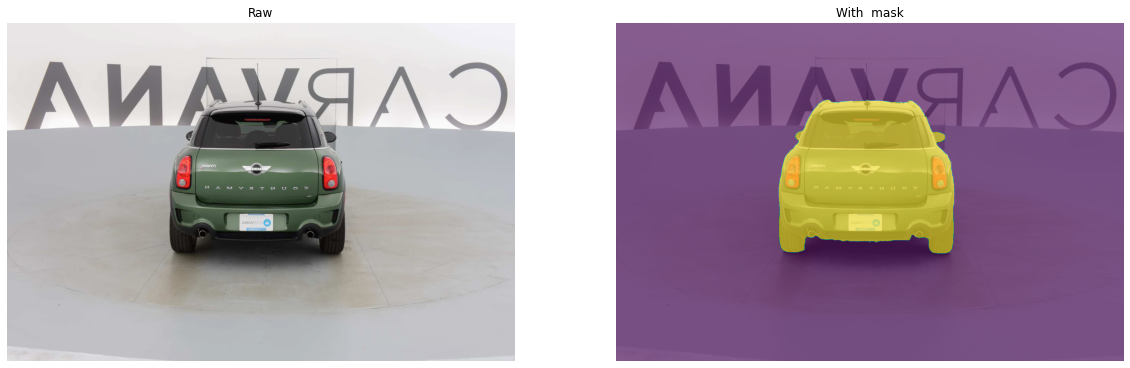

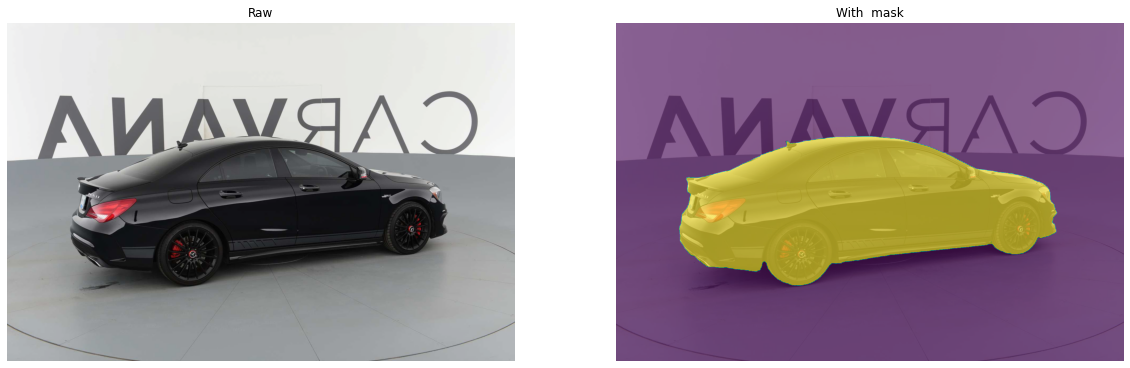

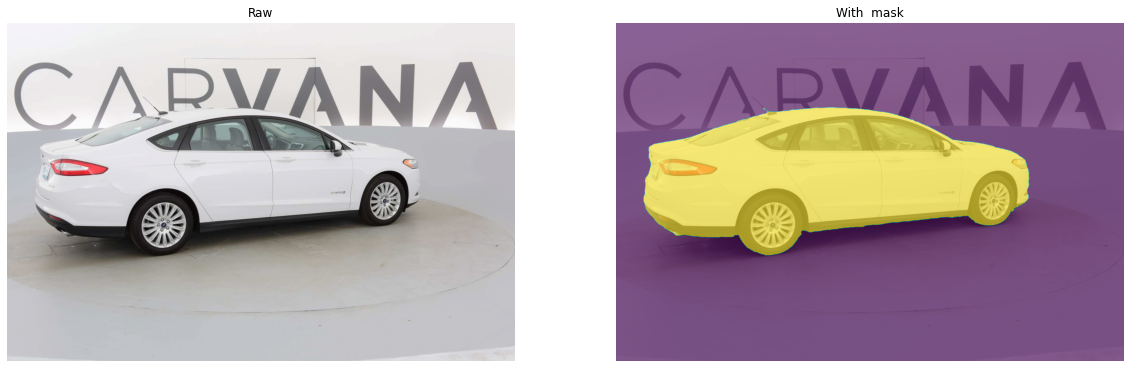

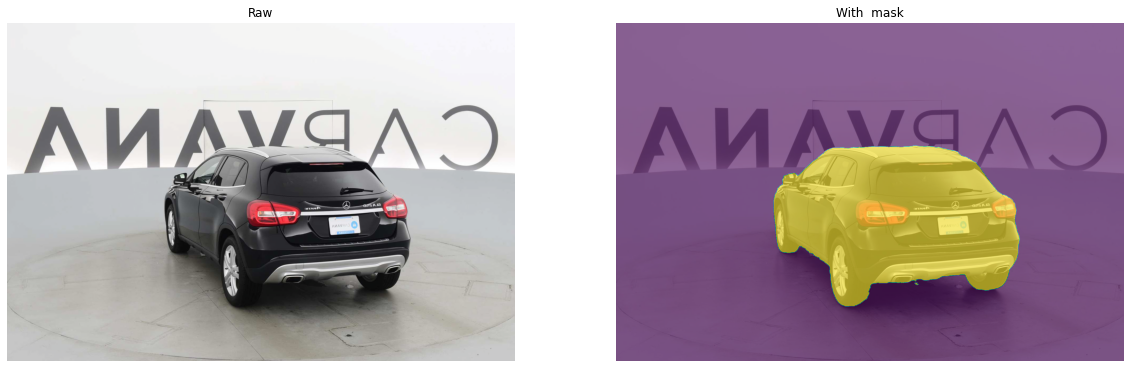

In [23]:
data, labels = next(iter(val_dataloader))
data = data.to(device)
res = model(data)
res = (torch.stack((res[:, 0], res[:, 1]), dim=3)). \
    reshape(res.shape[0]*res.shape[2]*res.shape[3], n_classes)
res = res.argmax(dim=1)
res = res.reshape(data.shape[0], img_h, img_w)
for real, test in zip(data, res):
    show_mask_above(real.cpu().detach(), test.cpu().detach())

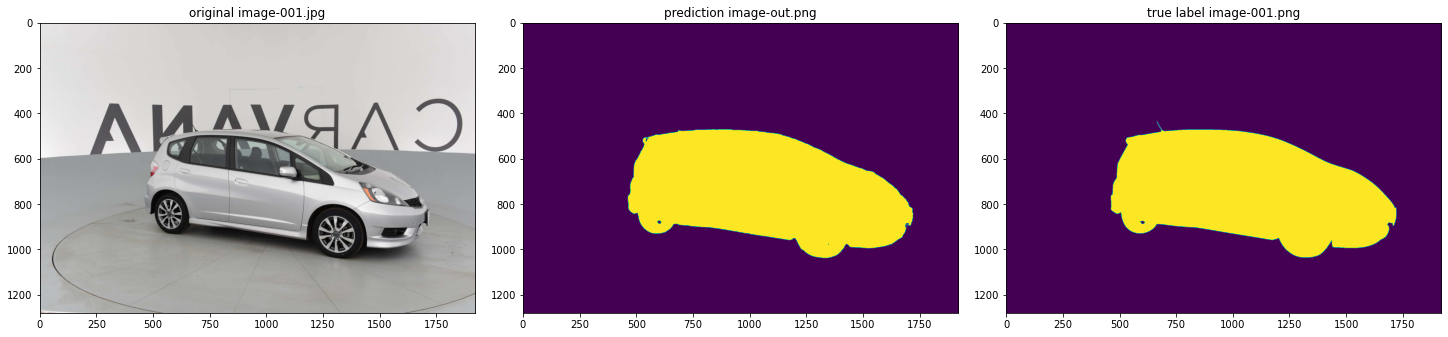

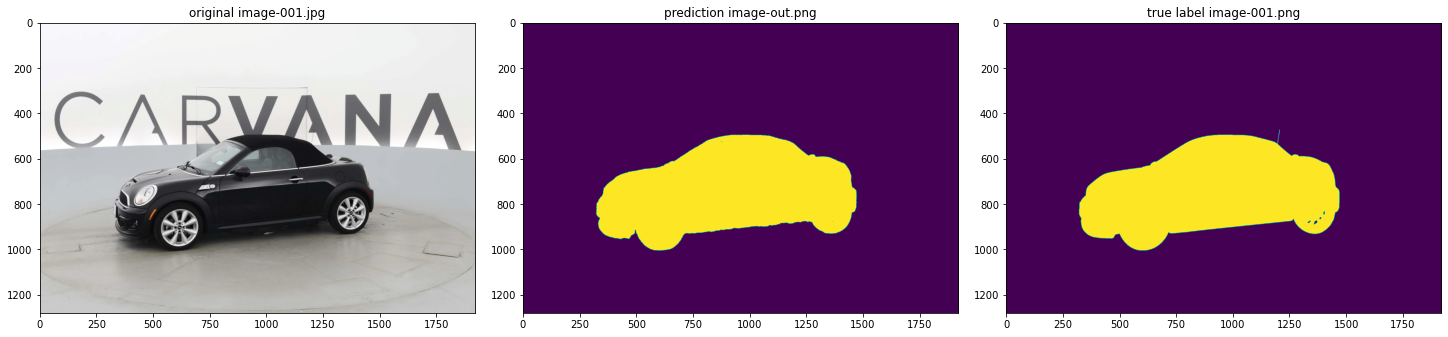

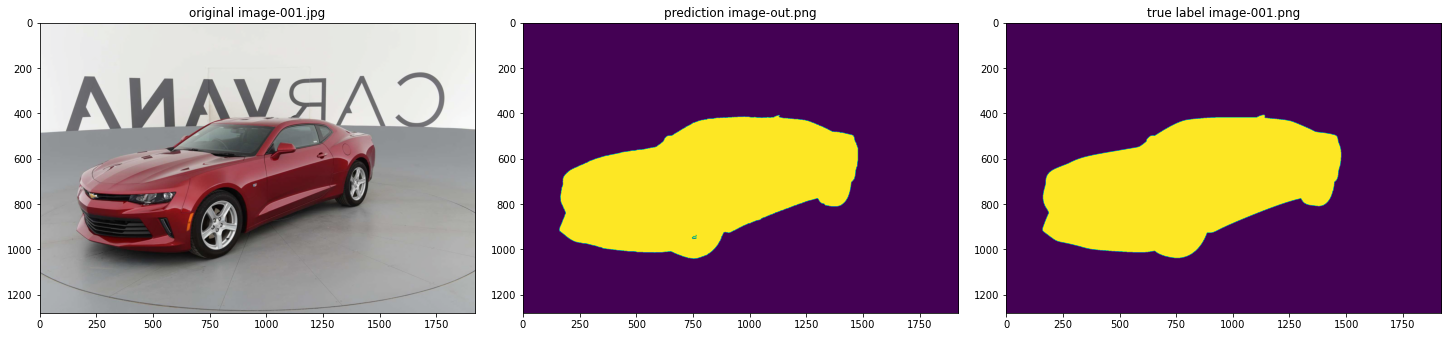

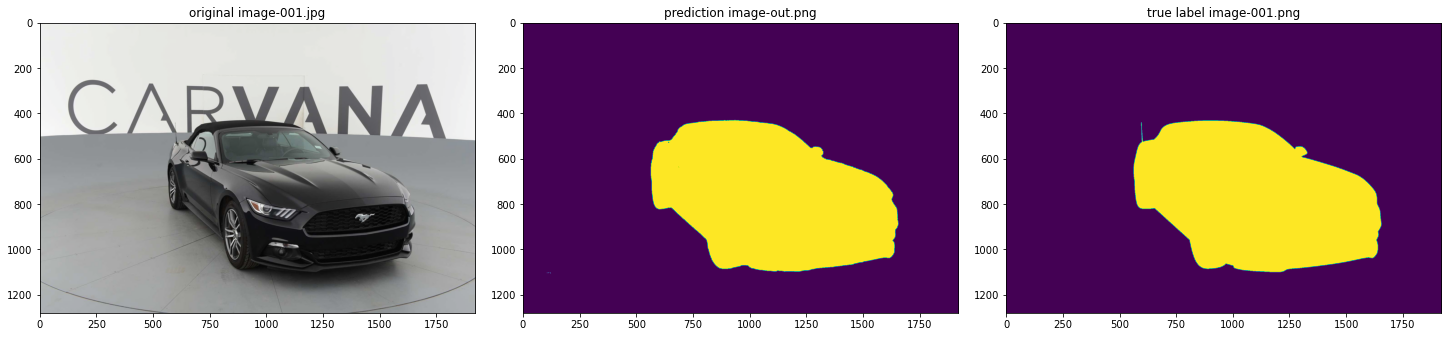

In [21]:
model.eval()
X_batch0, X_batch1 = next(iter(val_dataloader))
X_batch0 = X_batch0.to(device)
g = X_batch0.clone()
res = model(X_batch0)
res = (torch.stack((res[:, 0], res[:, 1]), dim=3)). \
    reshape(res.shape[0]*res.shape[2]*res.shape[3], n_classes)
res = res.argmax(dim=1)
res = res.reshape(X_batch0.shape[0], img_h, img_w)

for imgr, imgg, imgb in zip(res, g, X_batch1):
    show_three(imgg.cpu().detach(), imgr.cpu().detach(), imgb)